<a href="https://colab.research.google.com/github/FedericoMiscione/Tesi/blob/master/Binary_Change_Detection_on_DEND.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

!pip install rasterio
import rasterio

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
import albumentations as A

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, jaccard_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 41.6 MB/s eta 0:00:00


Connessione al drive da cui prendere il dataset

In [ ]:
from google.colab import drive, files

drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [ ]:
# Check del device disponibile [GPU --> "cuda" || CPU --> "cpu"]
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print("Using PyTorch version: ", torch.__version__, " Device: ", device)

Using PyTorch version:  2.1.0+cu121  Device:  cuda


Definizione dei path e dei filename da cui prendere il dataset e suddividerlo in train, validation  e test set

In [ ]:
DATA_PATH = "/content/gdrive/My Drive/Dataset_progetto"
train_txt = "train.txt"
val_txt = "val.txt"
test_txt = "test.txt"

Implementazione della classe dataset con le opportune modifiche effettuate basandosi sulle osservazioni riguardanti il dataset specifico Dynamic Earth Net

In [ ]:
class DynamicEarthNetDataset(Dataset):

  def __init__(self, root, mode, transform=None, num_classes=7, ignored_classes=[]):
    super().__init__()

    # Path da cui caricare gli elementi del dataset
    self.root = root
    self.mode = mode
    self.transform = transform
    self.num_classes = num_classes
    self.ignored_classes = ignored_classes

    # mode: 0 [train] or 1 [validation] or 2 [test]
    # Utile per la suddivisione del dataset in train_set, validation_set e test_set
    self.train = False
    if self.mode == 0:
      self.txt_file = train_txt
      self.train = True
    elif self.mode == 1:
      self.txt_file = val_txt
    elif self.mode == 2:
      self.txt_file = test_txt
    else:
      print("Il valore del parametro mode non corretto..\nVerrà inizializzato di default il train set")
      self.mode = 0
      self.train = True

    # Data Augmentation
    aug_transform_with_label = []

    if self.train == True:
      aug_transform_with_label = [
          A.VerticalFlip(p=0.5),
          A.HorizontalFlip(p=0.5),
          A.RandomCrop(height=256, width=256, always_apply=True, p=1.0)
      ]

    self.dual_transform_l = A.Compose(aug_transform_with_label, p=1.0, additional_targets={'image2': 'image', 'mask' : 'mask'}, is_check_shapes=False)

    # liste delle immagini e delle relative mask
    self.imgs_list, self.masks_list = self.FilesLoader(self.txt_file)

  # Metodo utilizzato per caricamento dei file dal dataset
  def FilesLoader(self, txt_file):
    with open(os.path.join(self.root, txt_file), 'r') as f:
      files_list = f.read().splitlines()

    imgs_list = []
    masks_list = []
    for idx in range(len(files_list)):
      img_path, mask_path = files_list[idx].split()
      imgs_list.append(img_path)
      masks_list.append(mask_path)

    del files_list
    return imgs_list, masks_list

  def __len__(self):
    return len(self.imgs_list)

  # Metodo oer calcolo della media e della deviazione standard sul dataset
  # ATTENZIONE! Da utilizzare solo su train set
  def mean_n_std_calculator(self):
    mean = np.zeros((4,))
    std = np.zeros((4,))

    for filename in self.imgs_list:
      img = rasterio.open(os.path.join(self.root, filename)).read()
      img = img.astype(np.float32)
      mean += np.mean(img, axis=(1, 2))
      std += np.std(img, axis=(1, 2))

    mean /= len(self.imgs_list)
    std /= len(self.imgs_list)

    return mean, std

  # Metodo per ottenere le label di semantic segmentation riguardanti le classi LULC considerate
  def get_mask(self, label):
    mask = np.zeros((label.shape[1], label.shape[2]), dtype=np.int64)

    for i in range(self.num_classes):
      if i in self.ignored_classes:
        mask[label[i,:,:] == 255] = -1
      else:
        mask[label[i,:,:] == 255] = i

    return mask

  # Elementi della label tutti 0-1 (if pixel == -1 => pixel = 1)
  def label_mod(self, label):
    for i in range(label.shape[0]):
      for j in range(label.shape[1]):
        if label[i, j] != 0:
          label[i, j] = 1
        else:
          label[i, j] = 0

    return label

  # Metodo per ottenere la posizione geografica e la data dal filename
  def get_img_place_and_date(self, img_path):
    token_list = img_path.split("/")
    place, date = token_list[-2], token_list[-1]
    if date.endswith(".tif"):
      date = date.removesuffix(".tif")
    del token_list
    return place, date

  # Metodo per ottenere la posizione geografica e la data dal filename
  def get_mask_place_and_date(self, mask_path):
    token_list = mask_path.split("/")
    place, pos, date = token_list[-5], token_list[-2], token_list[-1]
    if pos in date:
      date = date.replace(pos, "")
    if date.endswith(".tif"):
      date = date.removesuffix(".tif")
    del token_list, pos
    return place, date

  def __getitem__(self, index):

    self.imgs_list = sorted(self.imgs_list)
    self.masks_list = sorted(self.masks_list)

    img = rasterio.open(os.path.join(self.root, self.imgs_list[index])).read()
    label1 = rasterio.open(os.path.join(self.root, "labels", self.masks_list[index])).read()
    mask1 = self.get_mask(label1)

    # Acquisizione seconda immagine per confronto basata sul period settato
    place, date = self.get_img_place_and_date(self.imgs_list[index])

    # indice scelto per confronto con l'immagine più distante in ordine di tempo
    idx2 = -1

    sp_list = []
    for i in range(len(self.imgs_list)):
      if place in self.imgs_list[i] and date not in self.imgs_list[i]:
        sp_list.append(self.imgs_list[i])

    sp_list = sorted(sp_list)
    img2 = rasterio.open(os.path.join(self.root, sp_list[idx2])).read()
    del sp_list

    # Acquisizione relativa mask per genarazione della label
    place, date_mask1 = self.get_mask_place_and_date(self.masks_list[index])

    sp_list = []
    for i in range(len(self.masks_list)):
      if place in self.masks_list[i] and date_mask1 not in self.masks_list[i]:
        sp_list.append(self.masks_list[i])

    sp_list = sorted(sp_list)
    label2 = rasterio.open(os.path.join(self.root, "labels", sp_list[idx2])).read()
    mask2 = self.get_mask(label2)
    del sp_list

    # Genesi della label finale
    label = mask1 - mask2
    label = self.label_mod(label)

    augmented_l = self.dual_transform_l(image=img.transpose(1, 2, 0).astype(np.float32), image2=img2.transpose(1, 2, 0).astype(np.float32), mask=label)
    img = augmented_l['image'].transpose(2, 0, 1)
    img2 = augmented_l['image2'].transpose(2, 0, 1)
    label = augmented_l['mask']

    img = torch.tensor(np.array(img), dtype=torch.float)
    img2 = torch.tensor(np.array(img2), dtype=torch.float)
    label = torch.tensor(np.array(label), dtype=torch.int)

    if self.transform is not None:
      img = self.transform(img)
      img2 = self.transform(img2)

    return img, img2, label

La media e la deviazione standard del train set sono state calcolate in un altro script per ogni banda delle immagini utilizzate nel train set, ossia 4 (RGB + Near-InfraRed) attraverso il metodo definito nella classe DENDataset

```
train_mean, train_std = train_set.mean_n_std_calculator()
```
Risultato:

```
Media train set:               [662.08290168, 868.34189029, 994.30149163, 2461.63487549]

Deviazione standard train set: [284.18335319, 319.44892298, 416.30562178,  590.34430898]
```

In [ ]:
transform = transforms.Compose([
    transforms.Normalize((662.08290168, 868.34189029, 994.30149163, 2461.63487549), (284.18335319, 319.44892298, 416.30562178, 590.34430898))
])

Definizione del train, validation e test set

In [ ]:
train_set = DynamicEarthNetDataset(DATA_PATH, 0, transform=transform)
valid_set = DynamicEarthNetDataset(DATA_PATH, 1, transform=transform)
test_set = DynamicEarthNetDataset(DATA_PATH, 2, transform=transform)

print(f"train_set size = {len(train_set)}, valid_set size = {len(valid_set)}, test_set size = {len(test_set)}")

train_set size = 90, valid_set size = 10, test_set size = 10


Definizione dei DataLoader del train, validation e test set

In [ ]:
batch_size = 4
num_threads = 2

train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=num_threads)
valid_loader = DataLoader(valid_set, batch_size, shuffle=False, num_workers=num_threads)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

----------------------------------------------------------------------------------------------------
### Visualizzazione delle immagini nel dataset

In [ ]:
def multispectral_to_rgb_visualization(img, lower_percentile=5, upper_percentile=95):
    """
    Function for converting a multispectral image to RGB for visualization.
    It clips the top and bottom 5% of the image intensities and then normalizes
    the image to [0, 255] uint8 range.

    Args:
        img: a numpy array of shape (C, H, W) where the first 3 channels are BGR

    Returns:
        img: a numpy array of type uint8 and shape (H, W, 3) representing the RGB image
    """
    assert isinstance(img, np.ndarray), "The input image must be a numpy array"

    img = img.transpose(1,2,0)
    img = img[:, :, :3]
    img = img[:, :, [2, 1, 0]]

    img = np.clip(img, np.percentile(img, lower_percentile), np.percentile(img, upper_percentile))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = (img * 255).astype(np.uint8)
    return img

def img_converter(img):
  img = img.numpy()
  img = multispectral_to_rgb_visualization(img)
  return img

def img_visualizer(dataloader=train_loader):
  dataiter = iter(dataloader)
  img1, img2, label = next(dataiter)

  for batch in range(batch_size):

    img_1 = img_converter(img1[batch])
    img_2 = img_converter(img2[batch])
    msk = label[batch].numpy()

    imgs = [img_1, img_2, msk]

    fig, axes = plt.subplots(1, 3, figsize=(9, 9))

    for i, ax in enumerate(axes.flat):
      ax.imshow(imgs[i])
      if i == 2:
        ax.set_title("Change Map")

      ax.set_axis_off()

    plt.show()
    del imgs

  del dataiter

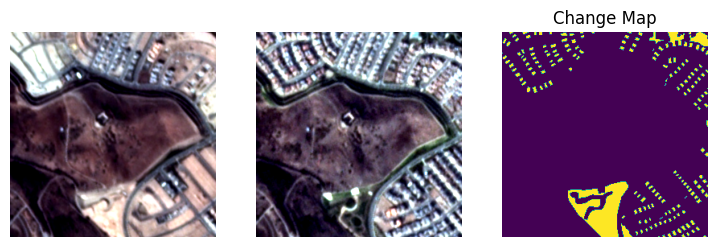

In [ ]:
img_visualizer(train_loader)

## Calcolo dei weights

Calcolo attraverso il seguente script che utilizza le label generate, che sono delle difference map, la percentuale dei changed pixel rispetto al totale.

```
def pixel_counter(label, total=0, changed=0):
  for i in range(label.shape[0]):
    for j in range(label.shape[1]):
      total += 1
      if label[i, j] != 0:
        changed += 1
  return total, changed

def weights_calculator():
    total_pixel, changed_pixel = 0, 0
    update_list = []
    for batch in tqdm(train_loader):
      _, _, label = batch

      for idx in range(batch_size):
        total, changed = pixel_counter(label[idx])
        total_pixel += total
        changed_pixel += changed
      change_ratio = changed_pixel / total_pixel
      update_list.append(change_ratio)

    change_ratio = changed_pixel / total_pixel
    return total_pixel, changed_pixel, change_ratio, update_list

total_pxl, changed_pxl, change_ratio, update_list = weights_calculator()
print(f"Pixel = {total_pxl}, Changed pixels = {changed_pxl} -> Change Ratio = {change_ratio}")
```
Con il seguente risultato:
```
100%|██████████| 6/6 [02:24<00:00, 24.13s/it]
Pixel = 5898240, Changed pixels = 1005307 -> Change Ratio = 0.17044186062282987
```

Quindi nel 17% dei pixel del train set è rilevato l'evento change, motivo per cui è opportuno applicare un peso per bilanciare le due classi.

-------------------------------------------------------------------------------------
#Definizione del modello di Rete Neurale

In [ ]:
class DoubleConvBlock(nn.Module):
  def __init__(self, in_ch, out_ch):
    super(DoubleConvBlock, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2)
    )
  def forward(self, x):
    return self.conv(x)

class U_Net(nn.Module):
  def __init__(self, in_ch=8, out_ch=1, layers=[32, 64, 128, 256]):
    super(U_Net, self).__init__()
    self.decoder = nn.ModuleList()
    self.encoder = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    for layer in layers:
      self.encoder.append(DoubleConvBlock(in_ch, layer))
      in_ch = layer

    for layer in reversed(layers):
      self.decoder.append(nn.ConvTranspose2d(layer*2, layer, kernel_size=2, stride=2))
      self.decoder.append(DoubleConvBlock(layer*2, layer))

    self.bridge = DoubleConvBlock(layers[-1], layers[-1]*2)
    self.final_conv = nn.Conv2d(layers[0], out_ch, kernel_size=1)

    self.sigmoid = nn.Sigmoid()

  def forward(self, x1, x2):
    skip_connections = []

    x = torch.cat((x1, x2), dim=1)

    for encoder in self.encoder:
      x = encoder(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bridge(x)

    skip_connections = skip_connections[::-1]

    for index in range(0, len(self.decoder), 2):
      x = self.decoder[index](x)
      skip_connection =  skip_connections[index//2]
      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.decoder[index+1](concat_skip)

    x = self.final_conv(x)
    return self.sigmoid(x)

In [ ]:
class FC_Siam_Conc(nn.Module):
  def __init__(self, in_ch=4, out_ch=1):
    super(FC_Siam_Conc, self).__init__()

    self.first_conv = nn.Sequential(
        nn.Conv2d(in_ch, 16, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2),
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2)
    )

    self.pool = nn.MaxPool2d(kernel_size=2)

    self.cb_1 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2),
        nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2)
    )

    self.cb_2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2)
    )

    self.cb_3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2)
    )

    self.tcb_1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1)

    self.tcb_2 = nn.Sequential(
        nn.ConvTranspose2d(384, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2),
        nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2),
        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2),
        nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2)
      )

    self.tcb_3 = nn.Sequential(
        nn.ConvTranspose2d(192, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2),
        nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2),
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2),
        nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2)
    )

    self.tcb_4 = nn.Sequential(
        nn.ConvTranspose2d(96, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2),
        nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2),
        nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2)
    )

    self.final_tcb = nn.Sequential(
        nn.ConvTranspose2d(48, 16, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(16, out_ch, kernel_size=3, stride=1, padding=1)
    )

    self.sigmoid = nn.Sigmoid()

  def single_branch(self, x):
    x1 = self.first_conv(x)
    x2 = self.cb_1(self.pool(x1))
    x3 = self.cb_2(self.pool(x2))
    x4 = self.cb_3(self.pool(x3))
    return x1, x2, x3, x4

  def forward(self, x, y):
    x1, x2, x3, x4 = self.single_branch(x)
    y1, y2, y3, y4 = self.single_branch(y)

    out = self.pool(y4)
    out = self.tcb_1(out)

    out = torch.cat((out, y4, x4), dim=1)
    out = self.tcb_2(out)

    out = torch.cat((out, y3, x3), dim=1)
    out = self.tcb_3(out)

    out = torch.cat((out, y2, x2), dim=1)
    out = self.tcb_4(out)

    out = torch.cat((out, y1, x1), dim=1)
    out = self.final_tcb(out)

    return self.sigmoid(out)

In [ ]:
model = U_Net().to(device)
# model = FC_Siam_Conc().to(device)
# print(model)

In [ ]:
# Calcolo del numero di parametri da addestrare nel modello
params = 0
for param in model.parameters():
  if param.requires_grad:
    params += param.numel()

print(f"Parametri addestrabili: {params}")

Parametri addestrabili: 7764481



UNET
```
Parametri addestrabili: 7764481
```
SIAMESE NET
```
Parametri addestrabili: 1546209
```

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

# Calcolo dei pesi
tot_pixel = 5898240
changed = 1005307
not_changed = tot_pixel - changed
pos_weight = torch.tensor(not_changed/tot_pixel, dtype=torch.float32).to(device)

In [ ]:
def train(loss_weights=pos_weight):
    model.train()
    epoch_loss = []
    all_labels, all_preds = [], []

    for img1, img2, label in tqdm(train_loader):
        img1, img2, label = img1.to(device=device, dtype=torch.float32), img2.to(device=device, dtype=torch.float32), label.to(device, dtype=torch.float32)
        optimizer.zero_grad()
        output = model(img1, img2)
        loss = nn.functional.binary_cross_entropy(output, label.view_as(output), weight=loss_weights)

        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()

        del img1, img2, label
        epoch_loss.append(loss.item())

    mean_loss = np.array(epoch_loss).mean()
    # Return average training loss for the epoch
    return mean_loss

def validate(loss_weights=pos_weight):
    model.eval()
    all_labels = []
    all_preds = []
    epoch_loss = []
    val_loss = 0
    n_elem = 0

    with torch.no_grad():
      for img1, img2, label in tqdm(valid_loader):
        img1, img2, label = img1.to(device=device, dtype=torch.float32), img2.to(device=device, dtype=torch.float32), label.to(device=device, dtype=torch.float32)

        output = model(img1, img2)

        epoch_loss.append(nn.functional.binary_cross_entropy(output, label.view_as(output), weight=loss_weights).item())

        preds = (output > 0.5).int()

        axes = None
        for batch in range(img1.shape[0]):
          _, axes = plt.subplots(1, 4, figsize=(16, 16))
          n_elem += 1
          for i, ax in enumerate(axes.flat):
            if i == 0:
              ax.imshow(img_converter(img1[batch].cpu()))
              ax.set_title("Image A")
              ax.set_axis_off()
            elif i == 1:
              ax.imshow(img_converter(img2[batch].cpu()))
              ax.set_title("Image B")
              ax.set_axis_off()
            elif i == 2:
              ax.imshow(preds[batch][0].cpu())
              ax.set_title("Prediction")
              ax.set_axis_off()
            else:
              ax.imshow(label[batch].cpu())
              ax.set_title("Label")
              ax.set_axis_off()

          plt.savefig(f'/content/gdrive/My Drive/Tesi/Validation_imgs/pic_{n_elem}.png')
          plt.close()

        del axes

        all_labels = np.concatenate((all_labels, label.flatten().cpu().int()))
        all_preds = np.concatenate((all_preds, preds.flatten().cpu().int()))

        del img1, img2, label

    val_loss = np.array(epoch_loss).mean()

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    del all_labels, all_preds

    return val_loss, accuracy, precision, recall, f1

def test(loss_weights=pos_weight):
    model.eval()
    all_labels = []
    all_preds = []
    test_loss = []
    n_elem = 0

    with torch.no_grad():
      for img1, img2, label in tqdm(test_loader):
        img1, img2, label = img1.to(device=device, dtype=torch.float32), img2.to(device=device, dtype=torch.float32), label.to(device=device, dtype=torch.float32)

        output = model(img1, img2)

        test_loss.append(nn.functional.binary_cross_entropy(output, label.view_as(output), weight=loss_weights).item())

        preds = (output > 0.5).int()

        axes = None
        for batch in range(img1.shape[0]):
          _, axes = plt.subplots(1, 4, figsize=(16, 16))
          n_elem += 1
          for i, ax in enumerate(axes.flat):
            if i == 0:
              ax.imshow(img_converter(img1[batch].cpu()))
              ax.set_title("Image A")
              ax.set_axis_off()
            elif i == 1:
              ax.imshow(img_converter(img2[batch].cpu()))
              ax.set_title("Image B")
              ax.set_axis_off()
            elif i == 2:
              ax.imshow(preds[batch][0].cpu())
              ax.set_title("Prediction")
              ax.set_axis_off()
            else:
              ax.imshow(label[batch].cpu())
              ax.set_title("Label")
              ax.set_axis_off()

          plt.savefig(f'/content/gdrive/My Drive/Tesi/test_results/pic_{n_elem}.png')
          plt.close()

        del axes

        all_labels = np.concatenate((all_labels, label.flatten().cpu().int()))
        all_preds = np.concatenate((all_preds, preds.flatten().cpu().int()))
        del img1, img2, label

    test_loss = np.array(test_loss).mean()

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    del all_labels, all_preds

    return test_loss, accuracy, precision, recall, f1, cm

class EarlyStopping():
    def __init__(self, patience=5, min_delta=0.0):

        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
restart_epoch = 1
NUM_EPOCHS = 100

early_stopping = EarlyStopping(patience=3, min_delta=0.01)

checkpoint_path = f'/content/gdrive/My Drive/Tesi/checkpoint/UNET/checkpoint_UNET_epoch_11.pt'

# Carica il checkpoint se esiste
if os.path.exists(checkpoint_path):
  checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  restart_epoch = checkpoint['epoch'] + 1 # Riprende dalla prossima epoca
  train_loss = checkpoint['loss']
  val_loss = checkpoint['validation loss']
  accuracy = checkpoint['accuracy']
  precision = checkpoint['precision']
  recall = checkpoint['recall']
  f1 = checkpoint['f1_score']
  print(f"Checkpoint loaded. Resuming training from Epoch {restart_epoch} with:")
  print(f"Train loss = {train_loss:.4f} | Validation loss = {val_loss:.4f}, Accuracy = {100*accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1_score = {f1:.4f}")
else:
  print(f"Checkpoint not found! Training from zero...")

for epoch in range(restart_epoch, NUM_EPOCHS):

  val_loss, accuracy, precision, recall, f1 = 0.0, 0.0, 0.0, 0.0, 0.0

  train_loss = train()
  print(f"Epoch {epoch}/{NUM_EPOCHS}, Training Loss: {train_loss:.4f}")

  print(f"Saving training stats for epoch {epoch}...")
  checkpoint = {
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': train_loss,
      'validation loss': val_loss,
      'accuracy' : accuracy,
      'precision' : precision,
      'recall' : recall,
      'f1_score' : f1
  }
  torch.save(checkpoint, f'/content/gdrive/My Drive/Tesi/checkpoint/UNET/checkpoint_UNET_epoch_{epoch}.pt')
  print("Training stats saved!")

  val_loss, accuracy, precision, recall, f1 = validate()
  print(f"Validation: Loss = {val_loss:.4f}, Accuracy = {100*accuracy:.2f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

  # Salvataggio del checkpoint dopo ogni epoca
  print(f"Saving validation stats for epoch {epoch}...")
  checkpoint = {
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': train_loss,
      'validation loss': val_loss,
      'accuracy' : accuracy,
      'precision' : precision,
      'recall' : recall,
      'f1_score' : f1
  }
  torch.save(checkpoint, f'/content/gdrive/My Drive/Tesi/checkpoint/UNET/checkpoint_UNET_epoch_{epoch}.pt')
  print("Validation stats saved!")

  early_stopping(train_loss, val_loss)
  if early_stopping.early_stop:
    print("We are at epoch:", epoch)
    break

  break

## Analisi dei risultati

In [ ]:
train_lossv, val_lossv, accv, precv, recv = [], [], [], [], []


for epoch in range(1, 12):
  checkpoint_path = f'/content/gdrive/My Drive/Tesi/checkpoint/UNET/checkpoint_UNET_epoch_{epoch}.pt'

  # Carica il checkpoint se esiste
  if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
    train_lossv.append(checkpoint['loss'])
    val_lossv.append(checkpoint['validation loss'])
    accv.append(checkpoint['accuracy'])
    precv.append(checkpoint['precision'])
    recv.append(checkpoint['recall'])
    f1 = checkpoint['f1_score']

In [ ]:
def plotter(vect, epochs, metric, title, n_vect=1):
  if n_vect == 1:
    sns.lineplot(x=epochs, y=vect, label=title)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend()
  elif n_vect > 1:
    for i in range(n_vect):
      sns.lineplot(x=epochs, y=vect[i], label=title[i])
    plt.title(metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend()

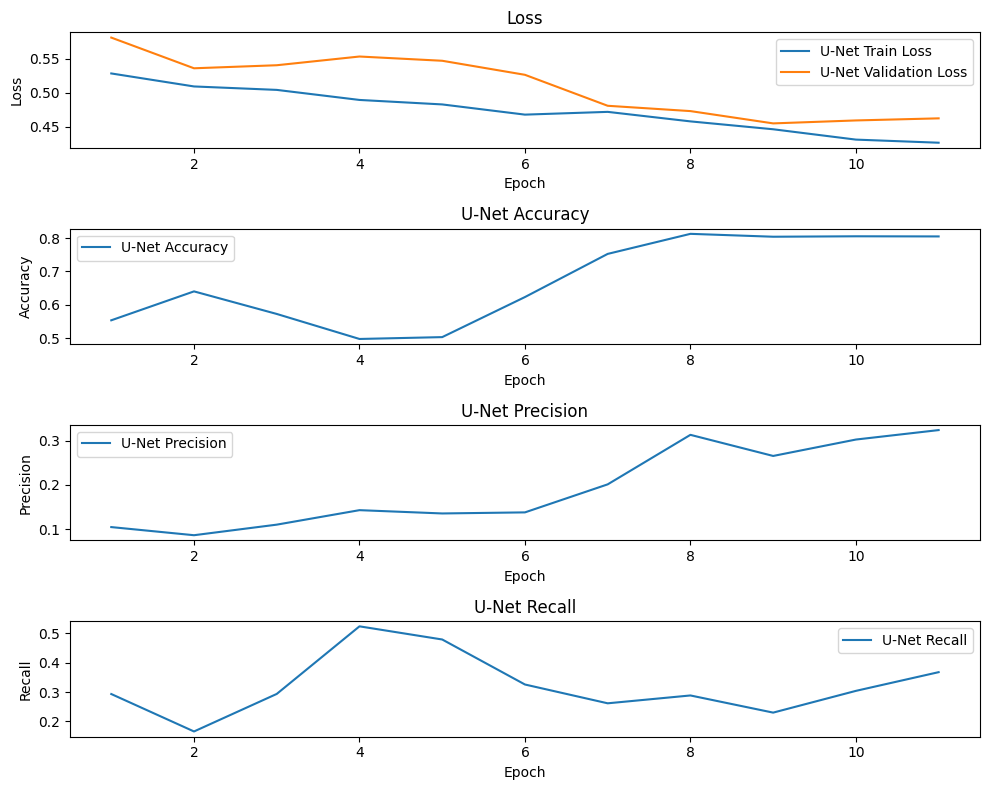

In [ ]:
epochs = np.arange(1, 12)
plt.figure(figsize=(10, 8))
# Loss plot
plt.subplot(4, 1, 1)
plotter([train_lossv, val_lossv], epochs, metric="Loss", title=["U-Net Train Loss", "U-Net Validation Loss"], n_vect=2)
# Accuracy
plt.subplot(4, 1, 2)
plotter(accv, epochs, metric="Accuracy", title="U-Net Accuracy")
# Precision
plt.subplot(4, 1, 3)
plotter(precv, epochs, metric="Precision", title="U-Net Precision")
# Recall
plt.subplot(4, 1, 4)
plotter(recv, epochs, metric="Recall", title="U-Net Recall")

plt.tight_layout()
plt.show()

**Analisi U-NET**

[DA COMPLETARE]



---



In [ ]:
siam_train_lossv, siam_val_lossv, siam_accv, siam_precv, siam_rec = [], [], [], [], []
for epoch in range(1, 94):
  checkpoint_path = f'/content/gdrive/My Drive/Tesi/checkpoint/SIAMNET/checkpoint_SIAMNET_epoch_{epoch}.pt'

  # Carica il checkpoint se esiste
  if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
    siam_train_lossv.append(checkpoint['loss'])
    siam_val_lossv.append(checkpoint['validation loss'])
    siam_accv.append(checkpoint['accuracy'])
    siam_precv.append(checkpoint['precision'])
    siam_rec.append(checkpoint['recall'])
    f1 = checkpoint['f1_score']

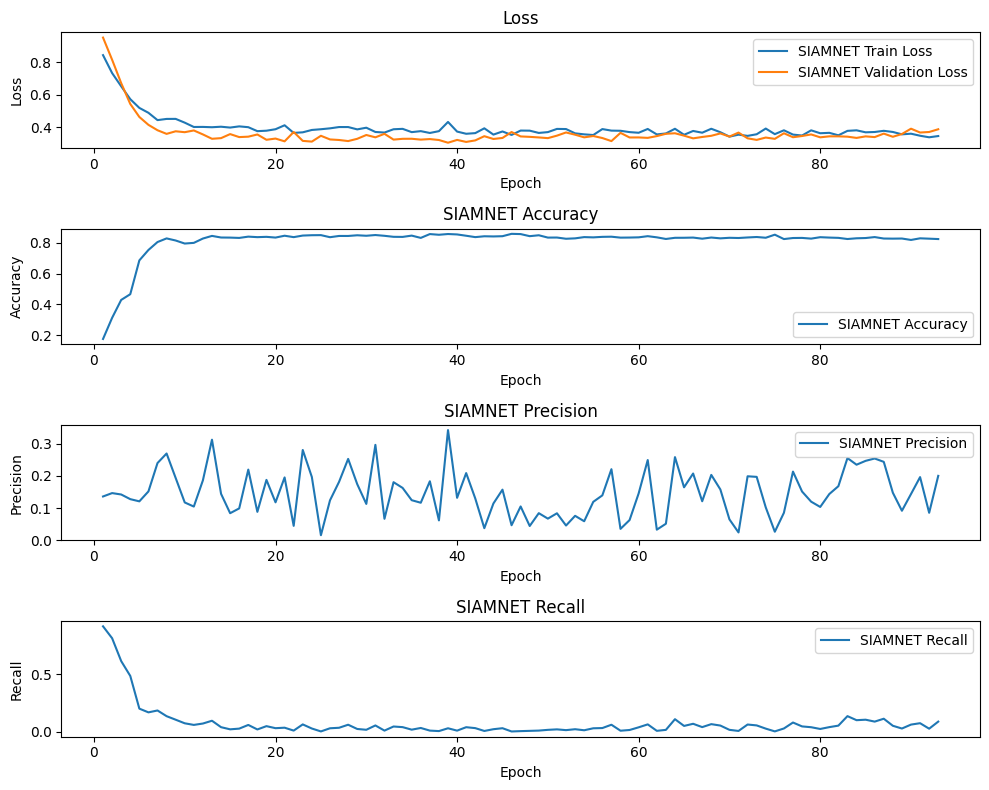

In [ ]:
epochs = np.arange(1, 94)
plt.figure(figsize=(10,8))
# Loss plot
plt.subplot(4, 1, 1)
plotter([siam_train_lossv, siam_val_lossv], epochs, metric="Loss", title=["SIAMNET Train Loss", "SIAMNET Validation Loss"], n_vect=2)
# Accuracy
plt.subplot(4, 1, 2)
plotter(siam_accv, epochs, metric="Accuracy", title="SIAMNET Accuracy")
# Precision
plt.subplot(4, 1, 3)
plotter(siam_precv, epochs, metric="Precision", title="SIAMNET Precision")
# Recall
plt.subplot(4, 1, 4)
plotter(siam_rec, epochs, metric="Recall", title="SIAMNET Recall")

plt.tight_layout()
plt.show()

**Analisi SIAMESE NET**

[DA COMPLETARE]

## Test

In [ ]:
test_loss, test_acc, test_prec, test_rec, test_f1, u_conf_mat = test()
print(f"Test: ")
print(f"  Loss = {test_loss:.4f}")
print(f"  Accuracy = {100*test_acc:.2f}%")
print(f"  Precision = {100*test_prec:.2f}%")
print(f"  Recall = {100*test_rec:.2f}%")
print(f"  F1-score = {test_f1:.4f}")

100%|██████████| 3/3 [02:31<00:00, 50.53s/it]


Test: 
  Loss = 0.4345
  Accuracy = 75.11%
  Precision = 22.56%
  Recall = 26.98%
  F1-score = 0.2457


**UNET Test results**

```
Test:
  Loss = 0.4345
  Accuracy = 75.11%
  Precision = 22.56%
  Recall = 26.98%
  F1-score = 0.2457
```

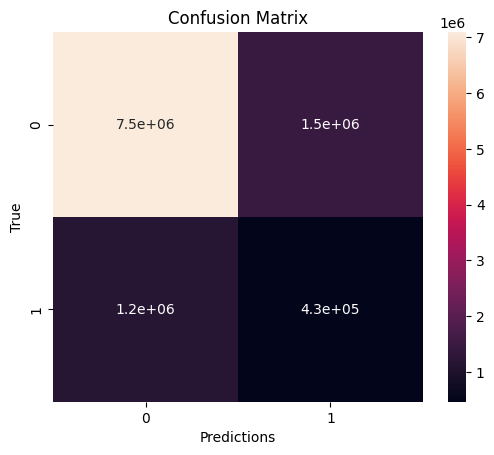

In [ ]:
sns.heatmap(u_conf_mat, annot=True, robust=True, cbar=True, square=True)

# Aggiungi etichette e titolo
plt.xlabel('Predictions')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Mostra il plot
plt.show()

In [ ]:
test_loss, test_acc, test_prec, test_rec, test_f1, conf_mat = test()
print(f"Test: ")
print(f"  Loss = {test_loss:.4f}")
print(f"  Accuracy = {100*test_acc:.2f}%")
print(f"  Precision = {100*test_prec:.2f}%")
print(f"  Recall = {100*test_rec:.2f}%")
print(f"  F1-score = {test_f1:.4f}")

100%|██████████| 3/3 [01:28<00:00, 29.60s/it]


Test: 
  Loss = 0.3488
  Accuracy = 85.04%
  Precision = 60.09%
  Recall = 1.32%
  F1-score = 0.0258


**SIAMESE NET Test results**

```
Test:
  Loss = 0.3488
  Accuracy = 85.04%
  Precision = 60.09%
  Recall = 1.32%
  F1-score = 0.0258
```

**SIAMESE NET Confusion Matrix**

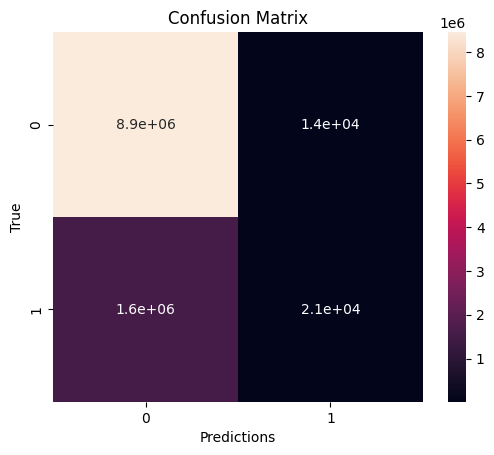

In [ ]:
sns.heatmap(conf_mat, annot=True, robust=True, cbar=True, square=True)

# Aggiungi etichette e titolo
plt.xlabel('Predictions')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Mostra il plot
plt.show()